In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import torch
import joblib
from model import *

import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn import datasets
breast_cancer = datasets.load_breast_cancer()
data, labels = breast_cancer['data'], breast_cancer['target']
mu = np.mean(data, axis = 0)
std = np.std(data, axis = 0)
data = (data - mu) / std
print(data.shape)

(569, 30)


In [3]:
np.random.seed(2)
num_train = 469
num_noisy = 100
num_val = 50
num_test = 50
train_data, train_labels = data[:num_train,:], labels[:num_train].reshape(num_train, 1)
noisy_index = np.random.randint(0, num_train, num_noisy)
train_labels[noisy_index] = 1 - train_labels[noisy_index]

val_data, val_labels = data[num_train:num_train+num_val,:], labels[num_train:num_train+num_val].reshape(num_val, 1)

test_data, test_labels = data[num_train+num_val:, :], labels[num_train+num_val:].reshape(len(labels) - num_train - num_val, 1)

In [4]:
def train_approx(weights, x_train, y_train, x_val, y_val, x_test, y_test):
    
    learning_rate = 0.01
    weight_list = []
    train_loss = []
    val_loss = []
    val_acc = [] 
    test_acc = []
    
    x_var = Variable(torch.FloatTensor(x_train))
    y_var = Variable(torch.FloatTensor(y_train))
    
    x_val_var = Variable(torch.FloatTensor(x_val))
    y_val_var = Variable(torch.FloatTensor(y_val))
    
    test_var = Variable(torch.FloatTensor(x_test), requires_grad=True)
    
    LR = net(x_train.shape[1], 1)
    optimizer = torch.optim.SGD(LR.params(), lr=learning_rate)
    
    weight_list.append(weights.clone().detach().numpy())
    for i in range(100):
        LR.train()
        
        #Compute training loss
        y_f_hat = LR(x_var)
        cost = F.binary_cross_entropy_with_logits(y_f_hat, y_var, reduce = False)
        l_f = torch.mm(weights, cost)[0][0] / len(x_train)
        train_loss.append(l_f)
    
        #Upate model prarameters
        LR.zero_grad()
        grads = torch.autograd.grad(l_f, (LR.params()), create_graph=True)
        LR.update_params(learning_rate, source_params=grads)
        
        
        #Compute validation loss, you can change the cross entropy loss to other losses you need
        y_g_hat = LR(x_val_var)
        l_g_meta = F.binary_cross_entropy_with_logits(y_g_hat, y_val_var)
        val_loss.append(l_g_meta)
        
        #compute the bi-level gradients
        grad_eps = torch.autograd.grad(l_g_meta, weights, only_inputs = True)[0]
        
        #update weight
        weights = weights - 10000 *  grad_eps # the learning rate need to carefully tuned.
        weights = torch.clamp(weights, 0.0, 1.0)
        
        weight_list.append(weights.clone().detach().numpy())
        
    return weight_list, train_loss, val_loss, val_acc, test_acc

In [5]:
weights = Variable(0.5*torch.ones(1, train_data.shape[0]), requires_grad = True)
weight_list, train_loss, val_loss, val_acc, test_acc = train_approx(weights, train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [14]:
def plot_weight(iteration):
    noisy_weight = []
    clean_weight = []
    bins = np.linspace(0.0, 1.0, 20)
    for i in range(len(weight_list[iteration][0])):
        if i in noisy_index:
            noisy_weight.append(weight_list[iteration][0][i])
        else:
            clean_weight.append(weight_list[iteration][0][i])

    plt.hist([noisy_weight, clean_weight], bins, label=['Noisy', 'Clean'], color=['r','b'])
    plt.legend()

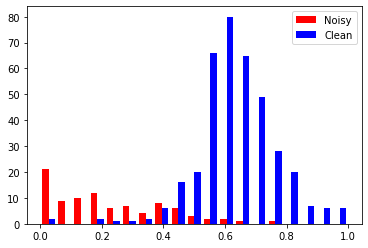

In [15]:
plot_weight(1)

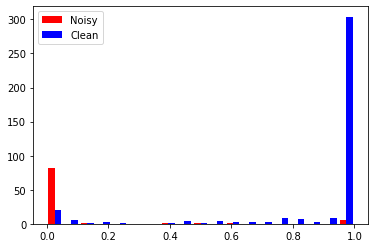

In [16]:
plot_weight(10)

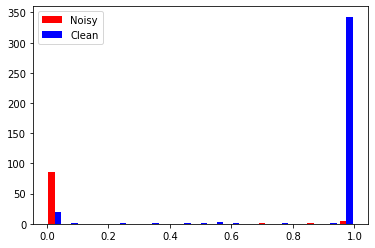

In [17]:
plot_weight(100)